In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import sys
import random

from tqdm import tqdm

import re
import string

import os

import shutil

import json

In [3]:
!pip install -q transformers

     |████████████████████████████████| 2.9 MB 5.2 MB/s 
     |████████████████████████████████| 3.3 MB 41.8 MB/s 
     |████████████████████████████████| 895 kB 56.6 MB/s 
     |████████████████████████████████| 596 kB 54.1 MB/s 
     |████████████████████████████████| 56 kB 4.0 MB/s 


In [4]:
from transformers import AutoTokenizer, TFBertMainLayer, TFBertForPreTraining, BertConfig, TFBertModel

In [5]:
import tensorflow as tf
from tensorflow.keras.losses import sparse_categorical_crossentropy as sce

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
f_train = '/content/drive/MyDrive/data/simplified-nq-train.jsonl'
f_test = '/content/drive/MyDrive/data/simplified-nq-test.jsonl'
num_train_samples = 307372
num_test_samples = 346

In [ ]:
#@title
def getSanCandidate(set_id, filename=f_train, debug=False):
    INSTANCE_WORDS_LEN = 500 
    STRIDE = 256 
    list_san_ins = []
    with open(filename) as f:
        progress = tqdm(f, total=num_train_samples)  
        for sam_count, line in enumerate(progress):
            if sam_count >= num_train_samples:
                break
                
            data = json.loads(line)
            example_id = str(data['example_id'])
            if example_id in set_id:
                # get lan result 
                ans_id = data['annotations'][0]['long_answer']['candidate_index']

                lan_start, lan_stop = -1, -1
                if ans_id > -1:
                    lan_start = data['long_answer_candidates'][ans_id]['start_token']
                    lan_stop = data['long_answer_candidates'][ans_id]['end_token']

                # if debug:
                #     print(example_id, lan_start, lan_stop)
                
                yes_no = data['annotations'][0]['yes_no_answer']
                if yes_no == "NONE":
                    is_yes_no = False
                else:
                    is_yes_no = True

                list_sans = data['annotations'][0]['short_answers']

                san_start, san_stop = lan_stop, lan_start

                for san in list_sans:
                    this_start, this_stop = san['start_token'], san['end_token']
                    if san_start > this_start: # start token should be smallest among short answers' start 
                        san_start = this_start
                    if san_stop < this_stop: # stop token should be largest among short answers' stop
                        san_stop = this_stop

                is_san = False
                if san_start < san_stop:
                    is_san = True

                doc_text = data['document_text']
                doc_text_split = doc_text.split()
                question = data['question_text']
                
                if lan_start > -1 and lan_stop > -1:
                    if lan_stop - lan_start <= INSTANCE_WORDS_LEN:
                        offset = (INSTANCE_WORDS_LEN - (lan_stop - lan_start))//2 
                        part_start = max(0,lan_start - offset)
                        part_stop = min(part_start + INSTANCE_WORDS_LEN, len(doc_text_split))

                        part_split = doc_text_split[part_start:part_stop]
                        context = ' '.join(part_split)
                        
                        if is_san:
                            ins_start = san_start - part_start
                            ins_stop = san_stop - part_start

                            ins = {'example_id': example_id, 'part_start': part_start, 'part_stop': part_stop, 
                                'question': question, 'context': context, 'start': ins_start, 'stop': ins_stop, 'target': 'SHORT'}
                            list_san_ins.append(ins) 
                            if debug:
                                print(ins['context'])
                                print(ins['target'], ins['context'].split()[ins_start:ins_stop])
                                print('\n')
                        elif is_yes_no:
                            ins_start = lan_start - part_start
                            ins_stop = lan_stop - part_start
                            ins = {'example_id': example_id, 'part_start': part_start, 'part_stop': part_stop, 
                                'question': question, 'context': context, 'start': ins_start, 'stop': ins_stop, 'target': yes_no}
                            list_san_ins.append(ins) 
                            if debug:
                                print(ins['context'])
                                print(ins['target'], ins['context'].split()[ins_start:ins_stop])
                                print('\n')
                        else:
                            ins_start = lan_start - part_start
                            ins_stop = lan_stop - part_start
                            ins = {'example_id': example_id, 'part_start': part_start, 'part_stop': part_stop, 
                                'question': question, 'context': context, 'start': ins_start, 'stop': ins_stop, 'target': 'LONG'}
                            list_san_ins.append(ins) 
                            if debug:
                                print(ins['context'])
                                print(ins['target'], ins['context'].split()[ins_start:ins_stop])
                                print('\n')
                    else: 
                        if is_san:
                            offset = (INSTANCE_WORDS_LEN - (san_stop - san_start))//2 
                            part_start = max(0,san_start - offset)
                            part_stop = min(part_start + INSTANCE_WORDS_LEN, len(doc_text_split))

                            part_split = doc_text_split[part_start:part_stop]
                            context = ' '.join(part_split)

                            ins_start = san_start - part_start
                            ins_stop = san_stop - part_start

                            ins = {'example_id': example_id, 'part_start': part_start, 'part_stop': part_stop, 
                                'question': question, 'context': context, 'start': ins_start, 'stop': ins_stop, 'target': 'SHORT'}
                            list_san_ins.append(ins) 
                            if debug:
                                print(ins['context'])
                                print(ins['target'], ins['context'].split()[ins_start:ins_stop])
                                print('\n')
                else:
                    # get random an ins
                    if len(doc_text_split) - INSTANCE_WORDS_LEN > 0:
                        part_start = random.randrange(0, len(doc_text_split) - INSTANCE_WORDS_LEN)       
                        part_stop = min(part_start + INSTANCE_WORDS_LEN, len(doc_text_split))

                        part_split = doc_text_split[part_start:part_stop]
                        context = ' '.join(part_split)
                        
                        ins_start, ins_stop = 0, 0

                        ins = {'example_id': example_id, 'part_start': part_start, 'part_stop': part_stop, 
                            'question': question, 'context': context, 'start': ins_start, 'stop': ins_stop, 'target': 'NO_ANSWER'}
                        list_san_ins.append(ins) 
                        if debug:
                            print(ins['context'])
                            print(ins['target'], ins['context'].split()[ins_start:ins_stop])
                            print('\n')

    return list_san_ins            

In [8]:
AnswerType = {
    'NO_ANSWER': 0,
    'YES': 1,
    'NO': 2,
    'SHORT' : 3,
    'LONG' : 4
}

def preprocess_data(data, tokenizer, debug=False): 
    progress = tqdm(data, total=len(data))
    x1 = []
    x2 = []
    x3 = []
    y = []
    for sam in progress:
        # part_id = sam['part_id']
        # part_tokens = f'[part={part_id}]'

        # context = part_tokens + " " + sam['context']
        tokenized_sam = tokenizer.encode_plus(sam['question'], sam['context'], 
                                              padding='max_length',
                                              truncation=True,
                                              max_length=512,
                                              add_special_tokens=True)
        
        x1.append(tf.cast(tokenized_sam['input_ids'], tf.int32))
        x2.append(tf.cast(tokenized_sam['token_type_ids'], tf.int32))
        x3.append(tf.cast(tokenized_sam['attention_mask'], tf.int32))

        y.append([sam['start'], sam['stop'], AnswerType[sam['target']]])

    x1 = tf.convert_to_tensor(x1)
    x2 = tf.convert_to_tensor(x2)
    x3 = tf.convert_to_tensor(x3)

    y = tf.convert_to_tensor(y)
    return x1, x2, x3, y


In [9]:
def get_strategy():
    try:
        tpu_cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
        print('Running on TPU ', tpu_cluster_resolver.cluster_spec().as_dict()['worker'])
        tf.config.experimental_connect_to_cluster(tpu_cluster_resolver)
        tf.tpu.experimental.initialize_tpu_system(tpu_cluster_resolver)
        strategy = tf.distribute.experimental.TPUStrategy(tpu_cluster_resolver)
    except ValueError as e:
        print(e)
        print('No TPU detected')
        tpu = None
        strategy = tf.distribute.get_strategy()
    return strategy

In [10]:
def create_model_san(tokenizer, model_name, debug=False):
    config = BertConfig()
    if debug:
        print(config)
    encoder = TFBertModel(config)
    # encoder = TFBertModel.from_pretrained(model_name)
    encoder.resize_token_embeddings(len(tokenizer))

    NUM_TARGET = 5
    class MyQAModel(tf.keras.Model):
        def __init__(self, *inputs, **kwargs):
            super().__init__(*inputs, **kwargs)            
            self.bert = encoder

            # self.dropout_start = tf.keras.layers.Dropout(0.1)
            # self.dropout_stop = tf.keras.layers.Dropout(0.1)
            # self.dropout_target = tf.keras.layers.Dropout(0.1)

            self.start_logits = tf.keras.layers.Dense(1)
            self.stop_logits = tf.keras.layers.Dense(1)
            
            self.target = tf.keras.layers.Dense(NUM_TARGET)

        def call(self, inputs, **kwargs):
            bert_res=self.bert(inputs[0], 
                               token_type_ids=inputs[1], 
                               attention_mask=inputs[2]
                               )
            
            # dropout_res1 = self.dropout_start(bert_res[0])
            dropout_res1 = bert_res[0]

            start_logits = tf.squeeze(self.start_logits(dropout_res1), -1)

            # dropout_res2 = self.dropout_stop(bert_res[0])
            dropout_res2 = bert_res[0]

            stop_logits = tf.squeeze(self.stop_logits(dropout_res2), -1)

            # dropout_res3 = self.dropout_target(bert_res[1])
            dropout_res3 = bert_res[1]
            
            targets = self.target(dropout_res3)
            
            paddings = tf.constant([[0, 0,], [0, 512-NUM_TARGET]])
            targets = tf.pad(targets, paddings)
            
            res = tf.stack([start_logits, stop_logits, targets], axis=1)
            return res
        
    model = MyQAModel()
    return model 

In [11]:
model_name = 'bert-base-uncased'

tokenizer_san = AutoTokenizer.from_pretrained(model_name)

tags = ['<Dd>', '<Dl>', '<Dt>', '<H1>', '<H2>', '<H3>', '<Li>', '<Ol>', '<P>', '<Table>', '<Td>', '<Th>', '<Tr>', '<Ul>',
        '</Dd>', '</Dl>', '</Dt>', '</H1>', '</H2>', '</H3>', '</Li>', '</Ol>', '</P>', '</Table>', '</Td>', '</Th>', '</Tr>', '</Ul>',
        '<Th_colspan=', '</Th_colspan=', '``', '\'\'', '--']

# for i in range(0, 51, 1):
#     tags.append(f'[part={i}]')

print(tags)

special_tokens_dict = {'additional_special_tokens': tags}

num_added_toks = tokenizer_san.add_special_tokens(special_tokens_dict)
print(num_added_toks)
print(len(tokenizer_san))

# encoder.resize_token_embeddings(len(tokenizer))

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

['<Dd>', '<Dl>', '<Dt>', '<H1>', '<H2>', '<H3>', '<Li>', '<Ol>', '<P>', '<Table>', '<Td>', '<Th>', '<Tr>', '<Ul>', '</Dd>', '</Dl>', '</Dt>', '</H1>', '</H2>', '</H3>', '</Li>', '</Ol>', '</P>', '</Table>', '</Td>', '</Th>', '</Tr>', '</Ul>', '<Th_colspan=', '</Th_colspan=', '``', "''", '--']
33
30555


In [12]:
df_train_id = pd.read_csv('/content/drive/MyDrive/data/fine_data/train_id.csv', dtype=str)
set_train_id = set(df_train_id['example_id'].values.tolist())
print(len(set_train_id))

304299


In [85]:
list_instances = getSanCandidate(set_train_id, debug=False)

100%|██████████| 307372/307372 [07:46<00:00, 659.46it/s]


In [126]:
random.shuffle(list_instances)
print(len(list_instances))
list_instances_df = pd.DataFrame(list_instances)
list_instances_df.head()

296658


,example_id,part_start,part_stop,question,context,start,stop,target
0,-9045620313024580235,950,1450,all aboard the choo choo train girl name,in the Big Blue House </Li> <Li> PB&J Otter </...,0,0,NO_ANSWER
1,-1796144661756126845,280,780,who plays richard castle in the tv series castle,<Li> ABC Studios </Li> <Li> Beacon Pictures </...,208,210,SHORT
2,-1998564458996377690,695,1195,when did south korea became a developed country,Outlook : Stable </Li> <Li> Moody 's : Aa2 Out...,0,0,NO_ANSWER
3,8255870843864160419,6384,6884,when was the new year changed to january,Style Dates and the change to the Gregorian Ca...,0,0,NO_ANSWER
4,-5007025094863012729,730,1229,when was the last time the san francisco giant...,the legendary Polo Grounds . They have won 23 ...,256,257,SHORT


## **Load instances**

In [128]:
train_ins = '/content/drive/MyDrive/data/fine_data/train_instance_128_clean_975.csv'
val_ins = '/content/drive/MyDrive/data/fine_data/val_instance_128_clean.csv'

val_id = '/content/drive/MyDrive/data/fine_data/val_id.csv'
train_id = '/content/drive/MyDrive/data/fine_data/train_id.csv'

san_train_ins = '/content/drive/MyDrive/data/fine_data/train_san_ins.csv'

val_cand = '/content/drive/MyDrive/data/fine_data/val_mapping.csv'
gt = '/content/drive/MyDrive/data/fine_data/validation_long.csv'
gt_short = '/content/drive/MyDrive/data/fine_data/validation_short.csv'

In [130]:
train_ins_df = pd.read_csv(train_ins)
list_instances = train_ins_df.to_dict('records')
print(len(list_instances))

577571


In [131]:
for i in range(10):
    print(list_instances[i])

{'example_id': -6138284061475567910, 'part_id': 1, 'question': 'who is the book of romans written to', 'context': "Corinthians 2 Corinthians Galatians Ephesians Philippians Colossians 1 Thessalonians 2 Thessalonians 1 Timothy 2 Timothy Titus Philemon Hebrews James 1 Peter 2 Peter 1 John 2 John 3 John Jude Apocalypse Revelation New Testament manuscripts The Epistle to the Romans or Letter to the Romans , often shortened to Romans , is the sixth book in the New Testament . Biblical scholars agree that it was composed by the Apostle Paul to explain that salvation is offered through the gospel of Jesus Christ . It is the longest of the Pauline epistles and is often considered his `` most important theological legacy '' and magnum opus . Contents 1 General presentation 2 Authorship 3 Dating 4 Subscriptions 5 Paul 's life in relation to his epistle 6 The churches in Rome 7 Style 8 Purposes of writing 9 Contents 9.1 Prologue ( 1 : 1 -- 15 ) 9.1. 1 Greeting ( 1 : 1 -- 7 ) 9.1. 2 Prayer of Than

In [132]:
x_train1, x_train2, x_train3, y_train = preprocess_data(list_instances[0:100000], tokenizer_san)

100%|██████████| 100000/100000 [07:12<00:00, 230.99it/s]


In [120]:
san_ins_df = pd.read_csv('/content/drive/MyDrive/data/fine_data/san_val_instance.csv')
san_ins_list = san_ins_df.to_dict('records')
print(len(san_ins_list))

2755


In [133]:
strategy = get_strategy()
# weight_path =  '/content/drive/MyDrive/data/models/model6-squad-only/weights-14-0.588.h5'
weight_path = '/content/drive/MyDrive/data/models/stride-192/weights-04.h5'
with strategy.scope():
    sanModel = create_model_san(tokenizer_san, model_name)

    if os.path.isfile(weight_path):
        x = np.ones([1, 512], dtype=int)
        sanModel.predict([x, x, x])
        sanModel.load_weights(weight_path)

    opt = tf.keras.optimizers.Adam(learning_rate=0.000005, clipnorm=1.0)
    lossSCE = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metricSCA = tf.keras.metrics.SparseCategoricalAccuracy()
    sanModel.compile(optimizer=opt, loss=lossSCE, metrics=[metricSCA], run_eagerly=False)

Running on TPU  ['10.42.160.42:8470']
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.42.160.42:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.42.160.42:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int64>]


In [134]:
save_locally = tf.train.CheckpointOptions(experimental_io_device='/job:localhost')


filepath1="/content/drive/MyDrive/data/models/current/weights-{epoch:02d}.h5"
checkpoint_dir1 = os.path.dirname(filepath1)
checkpoint1 = tf.keras.callbacks.ModelCheckpoint(filepath1, 
                                                verbose=1, 
                                                save_weights_only=True,
                                                options=save_locally)
# earlyStop1 = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=5)

In [135]:
history1 = sanModel.fit(x=[x_train1, x_train2, x_train3],
                        y=y_train,
                        batch_size=128,
                        callbacks=[checkpoint1], 
                        epochs=100, 
                        validation_split=0.05)
# print(sanModel.predict([x_train1[0:3], x_train2[0:3], x_train3[0:3]]))

Epoch 1/100


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None, 3) dtype=int32>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None, 3) dtype=int32>]


 21/743 [..............................] - ETA: 5:32 - loss: 1.7782 - sparse_categorical_accuracy: 0.5878

KeyboardInterrupt: ignored

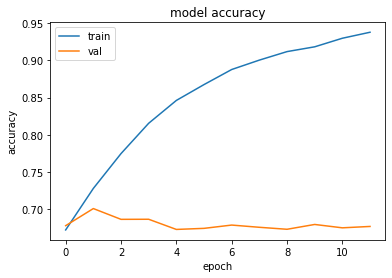

In [ ]:
# summarize history for accuracy
plt.plot(history1.history['sparse_categorical_accuracy'])
plt.plot(history1.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

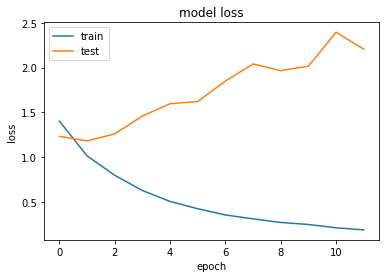

In [ ]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()